In [138]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from mne.decoding import CSP
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from mne.decoding import CSP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [139]:
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

numpy dataの読み込み

In [140]:
day1_movement_data = np.load('numpy_data/subject3_motor_data1.npy')
day2_movement_data = np.load('numpy_data/subject3_motor_data2.npy')
day1_imageMove_data = np.load('numpy_data/subject3_data1.npy')
day2_imageMove_data = np.load('numpy_data/subject3_data2.npy')


In [141]:
day1_movement_data = scipy.stats.zscore(day1_movement_data)
day2_movement_data = scipy.stats.zscore(day2_movement_data)
day1_imageMove_data = scipy.stats.zscore(day1_imageMove_data)
day2_imageMove_data = scipy.stats.zscore(day2_imageMove_data)

In [142]:
#labelデータの作成
class_label = np.zeros(360,dtype=int)
class_label[120:] = 1

データの結合

In [143]:
brain_data = np.vstack([day1_movement_data,day2_movement_data,
day1_imageMove_data,day2_imageMove_data])

label_data = class_label

In [144]:
motor_brainAdress = [9,10,11,12,13,17,18,31,44,45,46,47,48,49,50,54,55]
data_numpy_task  = brain_data[:,motor_brainAdress,100*6:100*10]

In [145]:
np.shape(data_numpy_task)

(360, 17, 400)

In [146]:
info_motorbrain = ['FC3','FC1','C1','C3','C5','CP3','CP1','CPz','FC4','FC2',
'FCz','Cz','C2','C4','C6','CP4','CP2',]
info_motor = mne.create_info(ch_names=info_motorbrain, ch_types="eeg", sfreq=1024)
info_motor.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: FC3, FC1, C1, C3, C5, CP3, CP1, CPz, FC4, FC2, FCz, Cz, C2, C4, ...
 chs: 17 EEG
 custom_ref_applied: False
 dig: 20 items (3 Cardinal, 17 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 17
 projs: []
 sfreq: 1024.0 Hz
>

In [147]:
#train testの分割
X_train, X_test, Y_train, Y_test = train_test_split(data_numpy_task,label_data, test_size=0.25,random_state=42)
print(np.shape(X_train))

(270, 17, 400)


In [148]:
#時系列データのSVM
X_train_re = np.reshape(X_train,(270,17*400))
X_test_re = np.reshape(X_test,(90,17*400))
model_pre =SVC(kernel='linear')
model_pre.fit(X_train_re,Y_train)
print(model_pre.score(X_test_re, Y_test))

0.14444444444444443


In [149]:
#default CSP
# CSP(n_components=4, reg=None, log=None, cov_est='concat', transform_into='average_power'
#     , norm_trace=False, cov_method_params=None, rank=None, component_order='mutual_info')

In [150]:
csp = CSP(n_components=8, reg='empirical', log=True, cov_est='epoch', transform_into='average_power', 
          norm_trace=True, cov_method_params=None, rank='info', component_order='alternate')

Computing rank from data with rank='info'
    MAG: rank 17 after 0 projectors applied to 17 channels
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 17 after 0 projectors applied to 17 channels
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 17 after 0 projectors applied to 17 channels
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 17 after 0 projectors applied to 17 channels
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 17 after 0 projectors applied to 17 channels
Reducing data rank from 17 -> 17
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 17 after 0 projectors applied to 17 channels
Reducing 

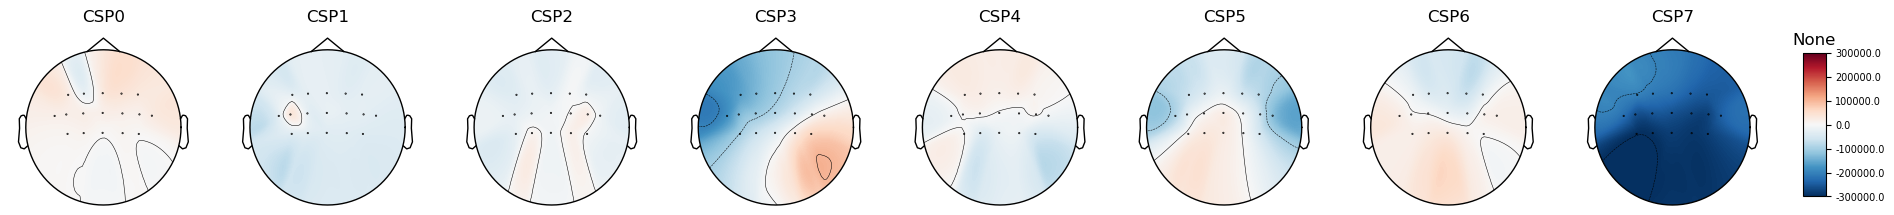

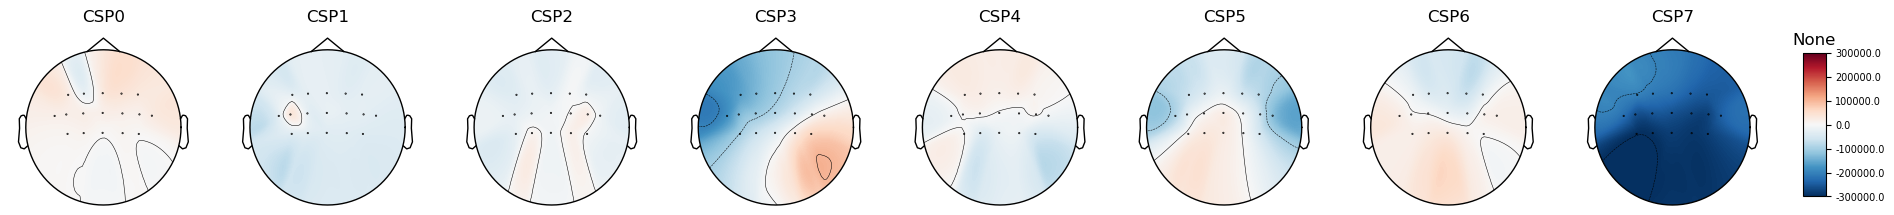

In [151]:
# plot CSP patterns estimated on full data for visualization
kenshou = csp.fit_transform(X_train, Y_train)
csp.fit_transform(X_train, Y_train)
csp.plot_patterns(info_motor,ch_type='eeg', units='None', size=1.5)

In [152]:
x_train_csp = csp.transform(X_train)
x_test_csp = csp.transform(X_test)

In [153]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
# 多層パーセプトロン
mlp_clf = MLPClassifier()
mlp_clf.fit(x_train_csp, Y_train)

mlp_clf.score(x_test_csp, Y_test)

/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8777777777777778

In [154]:
random_search = {'batch_size': [10, 20, 30, 130],
               'hidden_layer_sizes': [(150, 150), (100, 100, 50), (150, 100, 50)],
               'max_iter': [400, 500, 600, 700, 800],
               'random_state': [42]}
mlp_random_search2 = RandomizedSearchCV(mlp_clf, random_search, cv=3,
                                   n_jobs=-1, scoring='accuracy', random_state=0)
# スケーリングしたデータで実行します
mlp_random_search2.fit(x_train_csp, Y_train)

RandomizedSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
                   param_distributions={'batch_size': [10, 20, 30, 130],
                                        'hidden_layer_sizes': [(150, 150),
                                                               (100, 100, 50),
                                                               (150, 100, 50)],
                                        'max_iter': [400, 500, 600, 700, 800],
                                        'random_state': [42]},
                   random_state=0, scoring='accuracy')

In [155]:
# 実行
cvres = mlp_random_search2.cv_results_
for score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(score, params)

0.9259259259259259 {'random_state': 42, 'max_iter': 500, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 20}
0.8962962962962964 {'random_state': 42, 'max_iter': 400, 'hidden_layer_sizes': (100, 100, 50), 'batch_size': 30}
0.9074074074074074 {'random_state': 42, 'max_iter': 800, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 130}
0.9259259259259259 {'random_state': 42, 'max_iter': 700, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 20}
0.9222222222222222 {'random_state': 42, 'max_iter': 500, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 10}
0.9296296296296296 {'random_state': 42, 'max_iter': 600, 'hidden_layer_sizes': (150, 150), 'batch_size': 10}
0.9259259259259259 {'random_state': 42, 'max_iter': 800, 'hidden_layer_sizes': (150, 150), 'batch_size': 30}
0.9074074074074074 {'random_state': 42, 'max_iter': 700, 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 130}
0.9037037037037038 {'random_state': 42, 'max_iter': 400, 'hidden_layer_sizes': (150, 100, 50), 'batch_

In [156]:
mlp_random_search2.score(x_test_csp, Y_test)

0.9222222222222223

In [157]:
#時系列データのSVM
model =SVC(kernel='linear')
model.fit(x_train_csp,Y_train)
print(model.score(x_test_csp, Y_test))

0.9


In [158]:
params = {
    "C":np.logspace(-2,10,13),
    "kernel":["rbf","linear","sigmoid","poly"],
    "gamma":np.logspace(-9,3,13)
}
grid = GridSearchCV(model, params,scoring="accuracy", cv=5)

grid.fit(x_train_csp,Y_train)

print("grid_best_score=",grid.best_score_)
print(grid.best_params_)

pred = grid.predict(x_test_csp)
print(classification_report(Y_test, pred))

grid_best_score= 0.9333333333333332
{'C': 10000000.0, 'gamma': 0.001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.96      0.93      0.94        55

    accuracy                           0.93        90
   macro avg       0.93      0.94      0.93        90
weighted avg       0.93      0.93      0.93        90



In [159]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
#PCAを用意
pca = PCA(n_components=2)
#PCAで次元圧縮
pca.fit(x_train_csp)
#PCAの結果を元にデータを変換
pca_X = pca.transform(x_train_csp)

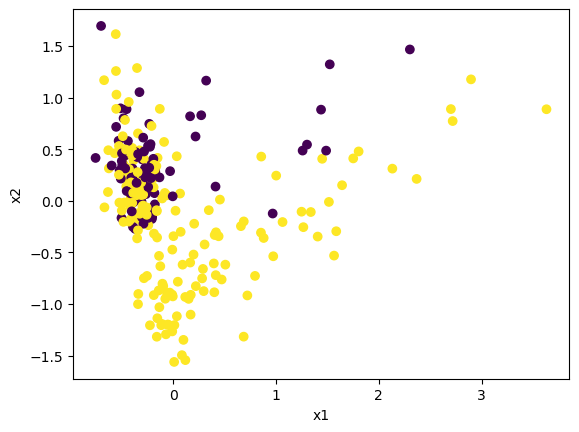

In [160]:
#SVNデータの点を表示
Z = grid.predict(x_train_csp)

plt.scatter(pca_X[:,0], pca_X[:,1], c=Z)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()